<a href="https://colab.research.google.com/github/cjsdudwls1/Aflatoxin_analysis/blob/main/3_%ED%8A%B9%EC%84%B1%EA%B3%B5%ED%95%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드

In [ ]:
import pandas as pd

data_DOWNSIZE = pd.read_pickle('/content/drive/MyDrive/df_fixed.pkl.gz')
display(data_DOWNSIZE.head())

,INSPCT_PURPS_NAME,PRDLST_NM,사용주소,x_coord,y_coord,tmprt_150_59,tmprt_150Top_59,tmprt_150Lwet_59,hd_150_59,arvlty_300_59,...,일조_55,일조_56,일조_57,일조_58,일조_59,JDGMNT_WORD_NAME,결과,결과값,Unnamed: 2,JDGMNT_WORD_NAME_encoded
0,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.2,7.3,9.9,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0
1,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.2,7.3,9.9,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0
2,자가품질위탁검사,과자,검사소,127.100161,37.279721,12.7,20.0,6.3,75.3,0.6,...,10.4,10.2,9.6,9.2,8.6,적합,불검출,0,"과자류, 빵류 또는 떡류",0
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,1.4,10.1,6.2,8.5,9.3,적합,불검출,0,건강기능식품(제품),0
4,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,1.4,10.1,6.2,8.5,9.3,적합,불검출,0,건강기능식품(제품),0


# 특성공학

Reference-based Aflatoxin Model Comparison Analysis
with Optimal Threshold Tuning

Step 1: Train and evaluate model with basic data

Data preprocessing started...
One-hot encoding features: ['INSPCT_PURPS_NAME', 'Unnamed: 2']
Train data shape: (141355, 622)
Test data shape: (17343, 622)
Train 'Non-compliant' ratio: 0.004584
Test 'Non-compliant' ratio: 0.009283

Basic RandomForest model training started...

Optimal Threshold Search:
  Metric: F1
  Optimal Threshold: 0.0100
  Best F1 Score: 0.017791

Basic RandomForest Model Evaluation Results:
--------------------------------------------------
Training time: 15.73s
Optimal Threshold: 0.0100
Accuracy:     0.726230
Precision:    0.009202
Recall:       0.267081
F1-Score:     0.017791
AP Score:     0.009244
ROC-AUC:      0.498176
--------------------------------------------------

Step 2: Apply reference-based feature engineering
Simple Reference-based Feature Engineering (3 features)
Original features: 610

1. Optimal temperature days for 

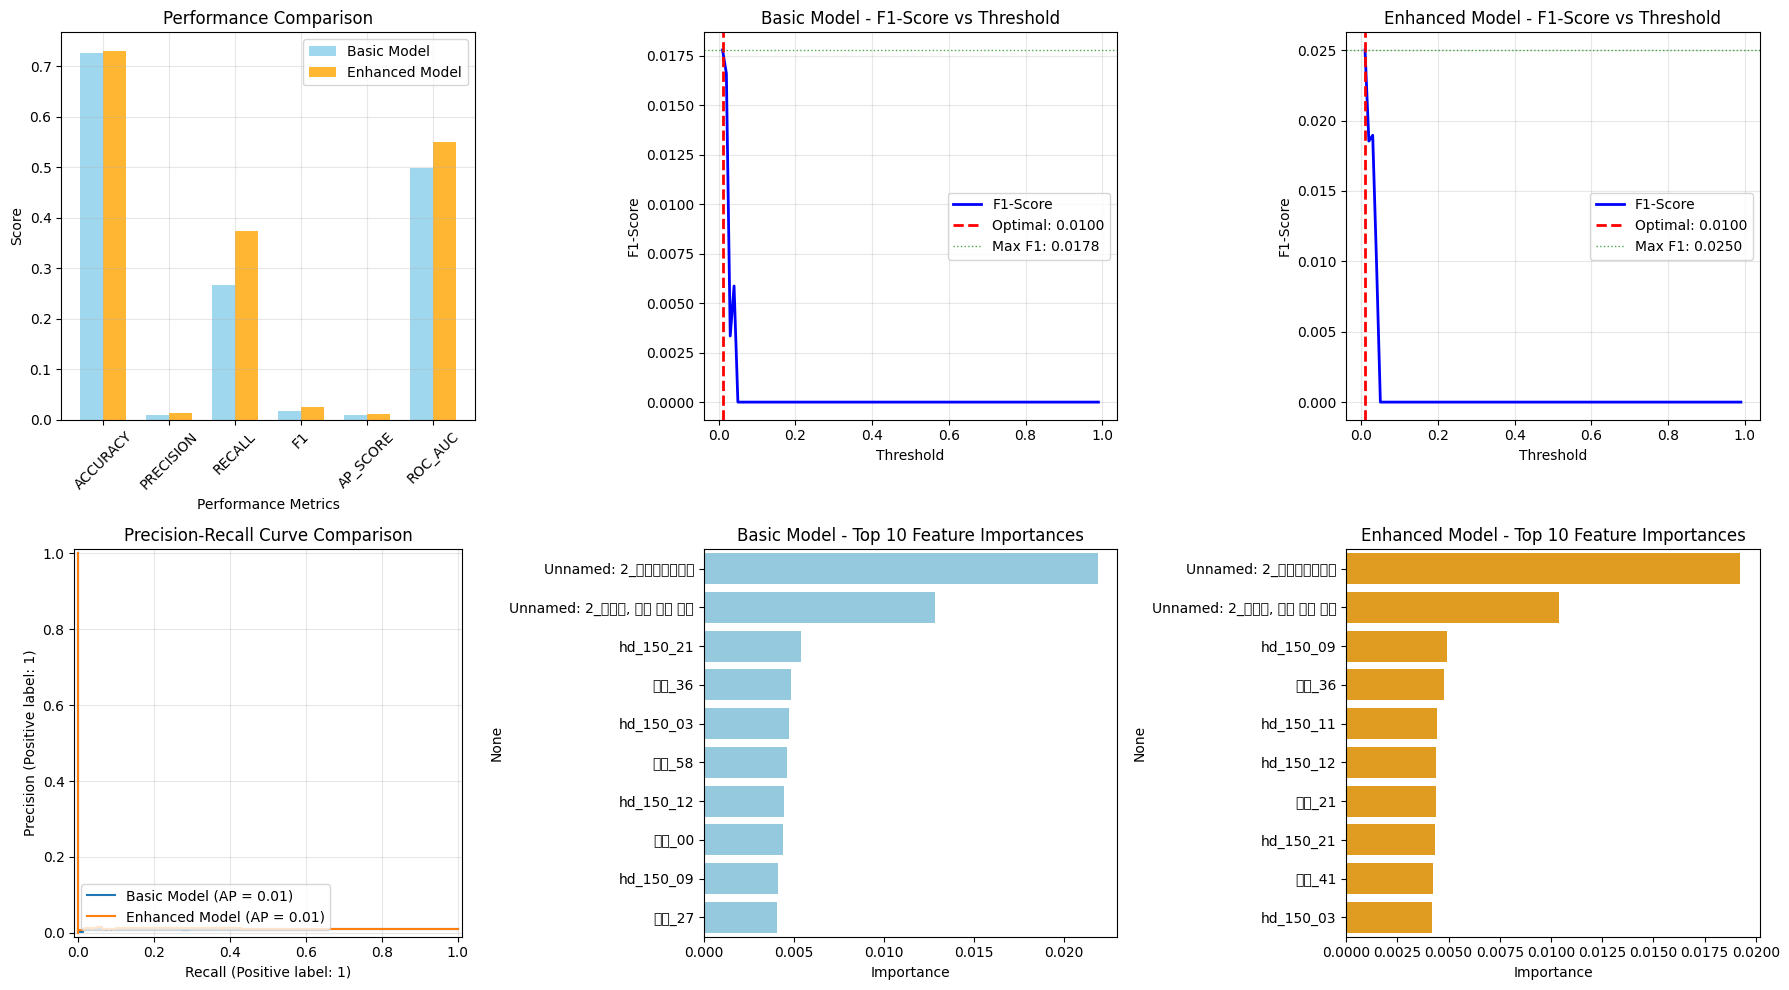


Reference-based Analysis Complete!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Global settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def find_optimal_threshold(y_true, y_pred_proba, metric='f1', verbose=True):
    """
    Find optimal threshold that maximizes the specified metric

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    metric : str
        Metric to optimize ('f1', 'precision', 'recall')
    verbose : bool
        Print detailed information

    Returns:
    --------
    optimal_threshold : float
        Optimal threshold value
    best_score : float
        Best score achieved
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    scores = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        if metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        else:
            score = f1_score(y_true, y_pred, zero_division=0)

        scores.append(score)

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    best_score = scores[optimal_idx]

    if verbose:
        print(f"\nOptimal Threshold Search:")
        print(f"  Metric: {metric.upper()}")
        print(f"  Optimal Threshold: {optimal_threshold:.4f}")
        print(f"  Best {metric.upper()} Score: {best_score:.6f}")

    return optimal_threshold, best_score, thresholds, scores

def create_simple_reference_features(data_DOWNSIZE, verbose=True):
    """
    Memory-efficient simple reference-based feature engineering
    Generate only 3 core features
    """
    df = data_DOWNSIZE.copy()
    original_columns = set(df.columns)

    if verbose:
        print("="*60)
        print("Simple Reference-based Feature Engineering (3 features)")
        print("="*60)
        print(f"Original features: {len(original_columns)}")

    window = 7

    # 1. Optimal temperature days for toxin production (25-35°C)
    if verbose:
        print("\n1. Optimal temperature days for toxin production...")
        print("   - Reference: FAO, 2001")

    temp_cols = [f'tmprt_150_{i:02d}' for i in range(window) if f'tmprt_150_{i:02d}' in df.columns]

    if temp_cols:
        temp_data = df[temp_cols].values
        optimal_temp_days = np.sum((temp_data >= 25) & (temp_data <= 35), axis=1)
        df['optimal_temp_days_7d'] = optimal_temp_days

    # 2. Low humidity days (<60%)
    if verbose:
        print("\n2. Low humidity days...")
        print("   - Reference: Gangneung-Wonju National University, 2014")

    humid_cols = [f'hd_150_{i:02d}' for i in range(window) if f'hd_150_{i:02d}' in df.columns]

    if humid_cols:
        humid_data = df[humid_cols].values
        low_humid_days = np.sum(humid_data < 60, axis=1)
        df['low_humid_days_7d'] = low_humid_days

    # 3. Consecutive dry days
    if verbose:
        print("\n3. Consecutive dry days...")
        print("   - Reference: Bowen & Hagan, 2015")

    rain_cols = [f'afp_{i:02d}' for i in range(window) if f'afp_{i:02d}' in df.columns]

    if rain_cols:
        rain_data = df[rain_cols].values
        drought_stress = np.zeros(len(df))
        for i in range(len(df)):
            row = rain_data[i]
            max_consecutive_dry = 0
            current_consecutive = 0
            for val in row:
                if np.isnan(val) or val == 0:
                    current_consecutive += 1
                    max_consecutive_dry = max(max_consecutive_dry, current_consecutive)
                else:
                    current_consecutive = 0
            drought_stress[i] = max_consecutive_dry

        df['drought_stress_7d'] = drought_stress

    new_columns = set(df.columns) - original_columns

    if verbose:
        print("\n" + "="*60)
        print("Reference-based Feature Engineering Complete!")
        print("="*60)
        print(f"Original features: {len(original_columns)}")
        print(f"Total features: {len(df.columns)}")
        print(f"New features: {len(new_columns)}")

        print(f"\nGenerated features:")
        for i, feature in enumerate(sorted(new_columns), 1):
            print(f"  {i:2d}. {feature}")
        print("="*60)

    feature_info = {
        'original_features': list(original_columns),
        'new_features': list(new_columns),
        'total_original': len(original_columns),
        'total_new': len(new_columns),
        'total_final': len(df.columns)
    }

    return df, feature_info

def prepare_data(data_DOWNSIZE, verbose=True):
    """Data preprocessing and splitting"""
    if verbose:
        print("\nData preprocessing started...")

    TARGET = 'JDGMNT_WORD_NAME_encoded'
    COLS_TO_DROP = ['결과값', '결과', 'JDGMNT_WORD_NAME', '사용주소', 'PRDLST_NM', 'x_coord', 'y_coord', TARGET]

    X = data_DOWNSIZE.drop(columns=COLS_TO_DROP)
    y = data_DOWNSIZE[TARGET]

    categorical_features = X.select_dtypes(include=['object']).columns
    if verbose:
        print(f"One-hot encoding features: {list(categorical_features)}")
    X = pd.get_dummies(X, columns=categorical_features, dummy_na=False)

    positive_indices = y[y == 1].index

    if len(positive_indices) < 5:
        split_point = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
        y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
    else:
        positive_split_idx = int(len(positive_indices) * 0.8)
        last_train_positive_index = positive_indices[positive_split_idx]
        split_point_location = X.index.get_loc(last_train_positive_index)

        X_train = X.iloc[:split_point_location + 1]
        y_train = y.iloc[:split_point_location + 1]
        X_test = X.iloc[split_point_location + 1:]
        y_test = y.iloc[split_point_location + 1:]

    if X_test.empty or y_test.empty:
        if verbose:
            print("Error: Test set is empty.")
        return None, None, None, None
    else:
        if verbose:
            print(f"Train data shape: {X_train.shape}")
            print(f"Test data shape: {X_test.shape}")
            print(f"Train 'Non-compliant' ratio: {y_train.mean():.6f}")
            print(f"Test 'Non-compliant' ratio: {y_test.mean():.6f}")

    return X_train, X_test, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name="RandomForest", verbose=True):
    """Train and evaluate RandomForest model with optimal threshold"""
    if verbose:
        print(f"\n{model_name} model training started...")

    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'
    )

    start_time = time.time()
    rf_model.fit(X_train, y_train)
    end_time = time.time()

    # Predict probabilities
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Find optimal threshold
    optimal_threshold, best_f1, thresholds, f1_scores = find_optimal_threshold(
        y_test, y_pred_proba, metric='f1', verbose=verbose
    )

    # Predict with optimal threshold
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    ap_score = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results = {
        'model': rf_model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'optimal_threshold': optimal_threshold,
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'ap_score': ap_score,
        'roc_auc': roc_auc,
        'training_time': end_time - start_time
    }

    if verbose:
        print(f"\n{model_name} Model Evaluation Results:")
        print("-" * 50)
        print(f"Training time: {end_time - start_time:.2f}s")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Accuracy:     {accuracy:.6f}")
        print(f"Precision:    {precision:.6f}")
        print(f"Recall:       {recall:.6f}")
        print(f"F1-Score:     {f1:.6f}")
        print(f"AP Score:     {ap_score:.6f}")
        print(f"ROC-AUC:      {roc_auc:.6f}")
        print("-" * 50)

    return results

def compare_models(basic_results, enhanced_results, X_test_basic, X_test_enhanced, y_test, verbose=True):
    """Compare model performance"""
    if verbose:
        print("\n" + "="*60)
        print("Reference-based Feature Engineering Model Comparison")
        print("="*60)

    metrics = ['accuracy', 'precision', 'recall', 'f1', 'ap_score', 'roc_auc']
    comparison_data = []

    for metric in metrics:
        basic_score = basic_results[metric]
        enhanced_score = enhanced_results[metric]
        improvement = enhanced_score - basic_score
        improvement_pct = (improvement / basic_score * 100) if basic_score != 0 else 0

        comparison_data.append({
            'Metric': metric.upper(),
            'Basic Model': f"{basic_score:.6f}",
            'Enhanced Model': f"{enhanced_score:.6f}",
            'Improvement': f"{improvement:+.6f}",
            'Improvement %': f"{improvement_pct:+.4f}%"
        })

    comparison_df = pd.DataFrame(comparison_data)

    if verbose:
        print(comparison_df.to_string(index=False))
        print(f"\nBasic Model Optimal Threshold: {basic_results['optimal_threshold']:.4f}")
        print(f"Enhanced Model Optimal Threshold: {enhanced_results['optimal_threshold']:.4f}")
        print("="*60)

    # Visualization
    fig = plt.figure(figsize=(18, 10))

    # 1. Performance metrics comparison
    ax1 = plt.subplot(2, 3, 1)
    metrics_names = [row['Metric'] for row in comparison_data]
    basic_scores = [float(row['Basic Model']) for row in comparison_data]
    enhanced_scores = [float(row['Enhanced Model']) for row in comparison_data]

    x = np.arange(len(metrics_names))
    width = 0.35

    ax1.bar(x - width/2, basic_scores, width, label='Basic Model', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, enhanced_scores, width, label='Enhanced Model', alpha=0.8, color='orange')
    ax1.set_xlabel('Performance Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. F1-Score vs Threshold (Basic Model)
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(basic_results['thresholds'], basic_results['f1_scores'],
             'b-', linewidth=2, label='F1-Score')
    ax2.axvline(basic_results['optimal_threshold'], color='r',
                linestyle='--', linewidth=2, label=f"Optimal: {basic_results['optimal_threshold']:.4f}")
    ax2.axhline(basic_results['f1'], color='g',
                linestyle=':', linewidth=1, alpha=0.7, label=f"Max F1: {basic_results['f1']:.4f}")
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('Basic Model - F1-Score vs Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. F1-Score vs Threshold (Enhanced Model)
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(enhanced_results['thresholds'], enhanced_results['f1_scores'],
             'b-', linewidth=2, label='F1-Score')
    ax3.axvline(enhanced_results['optimal_threshold'], color='r',
                linestyle='--', linewidth=2, label=f"Optimal: {enhanced_results['optimal_threshold']:.4f}")
    ax3.axhline(enhanced_results['f1'], color='g',
                linestyle=':', linewidth=1, alpha=0.7, label=f"Max F1: {enhanced_results['f1']:.4f}")
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('Enhanced Model - F1-Score vs Threshold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Precision-Recall Curve comparison
    ax4 = plt.subplot(2, 3, 4)
    display_basic = PrecisionRecallDisplay.from_estimator(
        basic_results['model'], X_test_basic, y_test, name='Basic Model', ax=ax4
    )
    display_enhanced = PrecisionRecallDisplay.from_estimator(
        enhanced_results['model'], X_test_enhanced, y_test, name='Enhanced Model', ax=ax4
    )
    ax4.set_title('Precision-Recall Curve Comparison')
    ax4.grid(True, alpha=0.3)

    # 5. Feature importance (Basic Model)
    ax5 = plt.subplot(2, 3, 5)
    importances_basic = pd.Series(basic_results['model'].feature_importances_,
                                   index=X_test_basic.columns)
    top_10_basic = importances_basic.sort_values(ascending=False).head(10)
    sns.barplot(x=top_10_basic.values, y=top_10_basic.index, ax=ax5, color='skyblue')
    ax5.set_title('Basic Model - Top 10 Feature Importances')
    ax5.set_xlabel('Importance')

    # 6. Feature importance (Enhanced Model)
    ax6 = plt.subplot(2, 3, 6)
    importances_enhanced = pd.Series(enhanced_results['model'].feature_importances_,
                                      index=X_test_enhanced.columns)
    top_10_enhanced = importances_enhanced.sort_values(ascending=False).head(10)
    sns.barplot(x=top_10_enhanced.values, y=top_10_enhanced.index, ax=ax6, color='orange')
    ax6.set_title('Enhanced Model - Top 10 Feature Importances')
    ax6.set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

    return comparison_df

def main():
    """Main execution function"""
    print("="*60)
    print("Reference-based Aflatoxin Model Comparison Analysis")
    print("with Optimal Threshold Tuning")
    print("="*60)

    try:
        pass
    except NameError:
        print("Error: data_DOWNSIZE variable is not defined.")
        print("Please load data and assign to data_DOWNSIZE variable.")
        return

    print("\nStep 1: Train and evaluate model with basic data")
    print("="*40)

    X_train_basic, X_test_basic, y_train, y_test = prepare_data(data_DOWNSIZE, verbose=True)

    if X_train_basic is None:
        print("Data preprocessing failed.")
        return

    basic_results = train_and_evaluate_model(
        X_train_basic, X_test_basic, y_train, y_test,
        model_name="Basic RandomForest", verbose=True
    )

    print("\nStep 2: Apply reference-based feature engineering")
    print("="*40)

    data_enhanced, feature_info = create_simple_reference_features(data_DOWNSIZE, verbose=True)

    X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = prepare_data(
        data_enhanced, verbose=True
    )

    if X_train_enhanced is None:
        print("Feature-engineered data preprocessing failed.")
        return

    enhanced_results = train_and_evaluate_model(
        X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced,
        model_name="Reference-based Enhanced RandomForest", verbose=True
    )

    print("\nStep 3: Model performance comparison")
    print("="*40)

    comparison_df = compare_models(
        basic_results, enhanced_results,
        X_test_basic, X_test_enhanced, y_test, verbose=True
    )

    print("\n" + "="*60)
    print("Reference-based Analysis Complete!")
    print("="*60)

    return {
        'basic_results': basic_results,
        'enhanced_results': enhanced_results,
        'comparison_df': comparison_df,
        'feature_info': feature_info
    }

# Execute
if __name__ == "__main__":
    results = main()

# 특성공학 한 데이터 피클로 저장

In [ ]:
import pandas as pd

data_DOWNSIZE = pd.read_pickle('/content/drive/MyDrive/df_fixed.pkl.gz')
display(data_DOWNSIZE.head())

,INSPCT_PURPS_NAME,PRDLST_NM,사용주소,x_coord,y_coord,tmprt_150_59,tmprt_150Top_59,tmprt_150Lwet_59,hd_150_59,arvlty_300_59,...,일조_55,일조_56,일조_57,일조_58,일조_59,JDGMNT_WORD_NAME,결과,결과값,Unnamed: 2,JDGMNT_WORD_NAME_encoded
0,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.2,7.3,9.9,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0
1,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.2,7.3,9.9,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0
2,자가품질위탁검사,과자,검사소,127.100161,37.279721,12.7,20.0,6.3,75.3,0.6,...,10.4,10.2,9.6,9.2,8.6,적합,불검출,0,"과자류, 빵류 또는 떡류",0
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,1.4,10.1,6.2,8.5,9.3,적합,불검출,0,건강기능식품(제품),0
4,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,1.4,10.1,6.2,8.5,9.3,적합,불검출,0,건강기능식품(제품),0


In [ ]:
import numpy as np
import pandas as pd

def create_simple_reference_features(data_DOWNSIZE, verbose=True):
    """
    Memory-efficient simple reference-based feature engineering
    Generate only 3 core features
    """
    df = data_DOWNSIZE.copy()
    original_columns = set(df.columns)

    if verbose:
        print("="*60)
        print("Simple Reference-based Feature Engineering (3 features)")
        print("="*60)
        print(f"Original features: {len(original_columns)}")

    window = 7

    # 1. Optimal temperature days for toxin production (25-35°C)
    if verbose:
        print("\n1. Optimal temperature days for toxin production...")
        print("   - Reference: FAO, 2001")

    temp_cols = [f'tmprt_150_{i:02d}' for i in range(window) if f'tmprt_150_{i:02d}' in df.columns]
    if temp_cols:
        temp_data = df[temp_cols].values
        optimal_temp_days = np.sum((temp_data >= 25) & (temp_data <= 35), axis=1)
        # --- [수정된 부분 1] ---
        df['독소 생성 최적 온도 일수'] = optimal_temp_days
        # ---------------------

    # 2. Low humidity days (<60%)
    if verbose:
        print("\n2. Low humidity days...")
        print("   - Reference: Gangneung-Wonju National University, 2014")

    humid_cols = [f'hd_150_{i:02d}' for i in range(window) if f'hd_150_{i:02d}' in df.columns]
    if humid_cols:
        humid_data = df[humid_cols].values
        low_humid_days = np.sum(humid_data < 60, axis=1)
        # --- [수정된 부분 2] ---
        df['저습도 일수'] = low_humid_days
        # ---------------------

    # 3. Consecutive dry days
    if verbose:
        print("\n3. Consecutive dry days...")
        print("   - Reference: Bowen & Hagan, 2015")

    rain_cols = [f'afp_{i:02d}' for i in range(window) if f'afp_{i:02d}' in df.columns]
    if rain_cols:
        rain_data = df[rain_cols].values
        drought_stress = np.zeros(len(df))
        for i in range(len(df)):
            row = rain_data[i]
            max_consecutive_dry = 0
            current_consecutive = 0
            for val in row:
                if np.isnan(val) or val == 0:
                    current_consecutive += 1
                    max_consecutive_dry = max(max_consecutive_dry, current_consecutive)
                else:
                    current_consecutive = 0
            drought_stress[i] = max_consecutive_dry
        # --- [수정된 부분 3] ---
        df['연속 무강수 일수'] = drought_stress
        # ---------------------

    new_columns = set(df.columns) - original_columns

    if verbose:
        print("\n" + "="*60)
        print("Reference-based Feature Engineering Complete!")
        print("="*60)
        print(f"Original features: {len(original_columns)}")
        print(f"Total features: {len(df.columns)}")
        print(f"New features: {len(new_columns)}")
        print(f"\nGenerated features:")
        # new_columns 세트가 동적으로 생성되므로, 정렬해서 출력해야 일관성이 있습니다.
        for i, feature in enumerate(sorted(list(new_columns)), 1):
            print(f"  {i:2d}. {feature}")
        print("="*60)

    feature_info = {
        'original_features': list(original_columns),
        'new_features': list(new_columns),
        'total_original': len(original_columns),
        'total_new': len(new_columns),
        'total_final': len(df.columns)
    }

    return df, feature_info

In [ ]:
import pandas as pd
import numpy as np # Add this line to import numpy

# Assuming data_DOWNSIZE is already loaded from previous steps
# If not, ensure it's loaded before running this cell

# Apply feature engineering to create the enhanced dataset
data_enhanced, _ = create_simple_reference_features(data_DOWNSIZE, verbose=False)
data_enhanced

,INSPCT_PURPS_NAME,PRDLST_NM,사용주소,x_coord,y_coord,tmprt_150_59,tmprt_150Top_59,tmprt_150Lwet_59,hd_150_59,arvlty_300_59,...,일조_58,일조_59,JDGMNT_WORD_NAME,결과,결과값,Unnamed: 2,JDGMNT_WORD_NAME_encoded,독소 생성 최적 온도 일수,저습도 일수,연속 무강수 일수
0,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
1,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
2,자가품질위탁검사,과자,검사소,127.100161,37.279721,12.7,20.0,6.3,75.3,0.6,...,9.2,8.6,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,4,1.0
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0
4,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169957,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169958,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169959,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169960,기타,기타기준규격외,제조공장,127.046083,36.219914,10.4,19.7,1.7,72.0,0.2,...,0.0,8.2,적합,불검출,0,기타식품류,0,0,0,6.0


In [ ]:
# Save the enhanced DataFrame to a pickle file
output_filename = '/content/drive/MyDrive/df_enhanced.pkl.gz'
data_enhanced.to_pickle(output_filename)

print(f"Feature-engineered data saved to {output_filename}")

Feature-engineered data saved to /content/drive/MyDrive/df_enhanced.pkl.gz


In [ ]:
import pandas as pd

data_enhanced = pd.read_pickle('/content/drive/MyDrive/df_enhanced.pkl.gz')
display(data_enhanced.head())

,INSPCT_PURPS_NAME,PRDLST_NM,사용주소,x_coord,y_coord,tmprt_150_59,tmprt_150Top_59,tmprt_150Lwet_59,hd_150_59,arvlty_300_59,...,일조_58,일조_59,JDGMNT_WORD_NAME,결과,결과값,Unnamed: 2,JDGMNT_WORD_NAME_encoded,독소 생성 최적 온도 일수,저습도 일수,연속 무강수 일수
0,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
1,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
2,자가품질위탁검사,과자,검사소,127.100161,37.279721,12.7,20.0,6.3,75.3,0.6,...,9.2,8.6,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,4,1.0
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0
4,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0


In [ ]:
data_enhanced = data_enhanced.rename(columns={'Unnamed: 2': '1차 식품 분류'})

In [ ]:
data_enhanced

,INSPCT_PURPS_NAME,PRDLST_NM,사용주소,x_coord,y_coord,tmprt_150_59,tmprt_150Top_59,tmprt_150Lwet_59,hd_150_59,arvlty_300_59,...,일조_58,일조_59,JDGMNT_WORD_NAME,결과,결과값,1차 식품 분류,JDGMNT_WORD_NAME_encoded,독소 생성 최적 온도 일수,저습도 일수,연속 무강수 일수
0,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
1,자가품질위탁검사,과자,제조공장,127.169855,37.436716,12.1,18.2,6.2,76.2,0.4,...,9.9,7.7,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,2,2.0
2,자가품질위탁검사,과자,검사소,127.100161,37.279721,12.7,20.0,6.3,75.3,0.6,...,9.2,8.6,적합,불검출,0,"과자류, 빵류 또는 떡류",0,0,4,1.0
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0
4,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),제조공장,126.770236,37.167154,12.5,20.8,5.6,80.8,0.4,...,8.5,9.3,적합,불검출,0,건강기능식품(제품),0,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169957,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169958,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169959,기타,기타기준규격외,제조공장,128.973543,36.045170,11.2,16.4,7.0,54.2,2.0,...,9.3,9.2,적합,불검출,0,기타식품류,0,0,7,7.0
169960,기타,기타기준규격외,제조공장,127.046083,36.219914,10.4,19.7,1.7,72.0,0.2,...,0.0,8.2,적합,불검출,0,기타식품류,0,0,0,6.0


In [ ]:
# Save the enhanced DataFrame to a pickle file
output_filename = '/content/drive/MyDrive/df_enhanced.pkl.gz'
data_enhanced.to_pickle(output_filename)

print(f"Feature-engineered data saved to {output_filename}")

Feature-engineered data saved to /content/drive/MyDrive/df_enhanced.pkl.gz
